# Prepare data in the format for modelling

In [71]:
import pandas as pd
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

def add_sin_and_cos_features(df, column_to_transform):
    df['Sin_{}'.format(column_to_transform)] = np.sin(2 * np.pi * df[column_to_transform] / max(df[column_to_transform])) 
    df['Cos_{}'.format(column_to_transform)] = np.cos(2 * np.pi * df[column_to_transform] / max(df[column_to_transform]))
    return df

def add_sin_and_cos_features(df, column_to_transform):
    df['Sin_{}'.format(column_to_transform)] = np.sin(2 * np.pi * df[column_to_transform] / len(df[column_to_transform].unique())) 
    df['Cos_{}'.format(column_to_transform)] = np.cos(2 * np.pi * df[column_to_transform] / len(df[column_to_transform].unique()))
    return df

from Functions import *

### Prepare footfall data
<u> Including removing outliers:</u>  
The model should predict normal footfall. Therefore any days that have extremely high or low footfall should be taken out of the training data. We don't actually want the model to try to predict footfall on unusual days, because the things that make the day unusual (like errors in the camera counters, or the presence of special events) are not captured in the input data.

Outliers are detected using the Median Absolute Deviation method.

In [72]:
# Read in data
sensors = pd.read_csv('../Cleaned_data/allsensors.csv')
# Create month as number not string
sensors['datetime'] =pd.to_datetime(sensors['datetime'], format = '%Y-%m-%d %H:%M:%S')#dayfirst = False)
# Keep only data from 2011 onwards
sensors= sensors[sensors['year']>2010]
# # Create a categrorial variable defining the time of day
sensors['time_of_day'] = sensors.apply (lambda row: label_hours(row), axis=1)
# Remove outliers
sensors = remove_outliers(sensors)
# Drop unneeded columns
sensors=sensors.drop(['Latitude', 'Longitude', 'location', 'mdate'], axis=1)
# Check the data
sensors.head()

I found 173692 outliers from 4208982 days in total. Removing them leaves us with 4035290 events


,sensor_id,datetime,year,month,day,time,hourly_counts,time_of_day
0,9,2011-01-01,2011,1,Saturday,0,241,nighttime
1,14,2011-01-01,2011,1,Saturday,0,704,nighttime
2,15,2011-01-01,2011,1,Saturday,0,1581,nighttime
3,8,2011-01-01,2011,1,Saturday,0,325,nighttime
4,18,2011-01-01,2011,1,Saturday,0,233,nighttime


In [73]:
sensors['day_of_month_num'] = sensors['datetime'].dt.day
sensors['weekday_num'] = sensors['datetime'].dt.weekday +1
sensors['month_num'] = sensors['datetime'].dt.month

### Join public holiday and weather data to sensor data (WHY DO NUMBER OF ROWS INCREASE SLIGHTLY?)

In [74]:
sensors_with_features = sensors.merge(pd.read_csv('../Cleaned_data/weather_data_allyears.csv', parse_dates=['datetime']), on='datetime', how='left')
sensors_with_features = sensors_with_features.merge(pd.read_csv('../Cleaned_data/publicholidays.csv', parse_dates=['datetime']),how='left', on='datetime')
sensors_with_features = sensors_with_features.merge(pd.read_csv('../Cleaned_data/schoolholidays.csv', parse_dates=['datetime']),how='left', on='datetime')
sensors_with_features = sensors_with_features.merge(pd.read_csv('../Cleaned_data/sensors_betweenness.csv'),how='left', on='sensor_id')
sensors_with_features = sensors_with_features.merge(pd.read_csv('../Cleaned_data/num_features_near_sensors_100.csv', index_col=0) ,how='left', on='sensor_id')
sensors_with_features = sensors_with_features.merge(pd.read_csv('../Cleaned_data/feature_subtypes_near_sensors_100_cleaned_buildings.csv', index_col=0) ,how='left', on='sensor_id')

In [48]:
print("Length is now: " , len(sensors_with_features))

Length is now:  4035307


### Add average number of floors of building in vicinity, for correct year 

In [75]:
sensors_with_features['avg_n_floors'] = sensors_with_features.apply (lambda row: select_n_floors(row), axis=1)
sensors_with_features = sensors_with_features[sensors_with_features.columns.drop(list(sensors_with_features.filter(regex='avg_n_floors_')))]

### Add buildings (correctly for the year the data relates to)

In [76]:
# FOR SENSORS WITH FEATURES
sensors_with_features['buildings'] = sensors_with_features.apply (lambda row: select_buildings(row), axis=1).copy()
sensors_with_features= sensors_with_features.drop(['buildings_2010', 'buildings_2011','buildings_2012', 'buildings_2013',
                                                  'buildings_2014','buildings_2015','buildings_2016','buildings_2017',
                                                  'buildings_2018', 'buildings_2019', 'buildings_2020'], axis =1)
# FOR SENSORS WITH SUBFEATURES
# Create a dataframe containing just the building subttypes for the year that this row refers to
temp = pd.DataFrame(None)
# For each year, get the data for just that year
for year in range(2011,2022+1):   
    # Get just footfall data for this year
    this_year = sensors_with_features[sensors_with_features['year'] == year]
    # If year is over 2020 then set the year to 2020 for the purposes of selecting the building data 
    if year > 2020:
        year = 2020
    # Get just the building columns for this year
    buildings_this_yr = this_year.filter(like='{}'.format(year))
    # Drop all the building subtype columns from the row (and the bikes) 
    this_year = this_year[this_year.columns.drop(list(this_year.filter(regex='bikes|buildings_')))]
     # Join the row without any buildings, back to this row 
    this_year = pd.concat([this_year, buildings_this_yr], axis=1)
    # Rename -- ??
    this_year.columns = this_year.columns.str.replace(r'_{}'.format(year), '')
    # Join to dataframe which will store data for all years eventually
    temp = temp.append(this_year)
sensors_with_features = temp.copy()

### Add dummy variables for calendar variables 
(Not doing this anymore as creating cos and sin variables)

In [8]:
# sensors_with_features=convert_df_variables_to_dummy(sensors_with_features, ['day', 'month', 'year', 'time'])
# sensors_with_features=convert_df_variables_to_dummy(sensors_with_features, ['time_of_day'])
# sensors_with_features = sensors_with_features.drop(['datetime'],axis=1)

### Create sin/cos variables to represent cyclical features

In [79]:
# Time refers to the hour of the day 0-23 (makes sense that this is cyclical - relationship between 23 and 0)
sensors_with_features = add_sin_and_cos_features(sensors_with_features, 'time')
# Month number from 1-12 (makes sense that this is cyclical - relationship between 12 and 1)
sensors_with_features = add_sin_and_cos_features(sensors_with_features, 'month_num')
# Weekday number from 1-7 (maybe doesnt make sense that this is cyclical - doesn't really follow a logical pattern?
sensors_with_features = add_sin_and_cos_features(sensors_with_features, 'weekday_num')

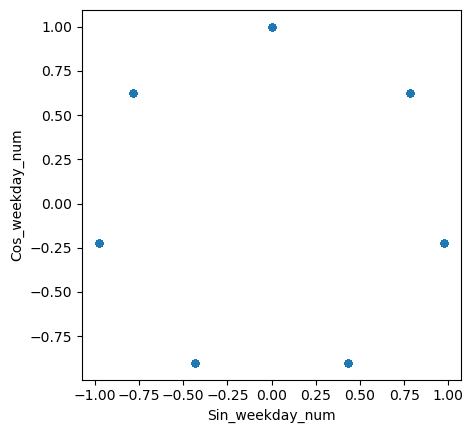

In [80]:
ax = sensors_with_features.plot.scatter('Sin_weekday_num', 'Cos_weekday_num').set_aspect('equal')

### Replace NaNs with 0s

In [81]:
sensors_with_features= sensors_with_features.fillna(0)

## Create aggregated data

In [ ]:
# ### Filter to include just sensors which we know have quite complete data 
# data = sensors_with_features[sensors_with_features['sensor_id'].isin([2,6,9,10,14,18])]
# data.reset_index(inplace=True, drop = True)

# # Get just this hourly counts
# hourly_counts = data[['datetime', "hourly_counts"]]
# # Get the sum of all values for one hour
# summed_hourly_counts = hourly_counts.groupby("datetime").sum()
# # reset index (for joining)
# summed_hourly_counts.reset_index(inplace = True, drop = True)

# # Get just the features
# features = data[['datetime','Temp', 'Humidity', 'Pressure', 'Rain', 'WindSpeed',
#        'public_holiday','school_holiday','Sin_time', 'Cos_time', 'Sin_month_num', 'Cos_month_num', 'Sin_weekday_num', 'Cos_weekday_num']]
# # Keep only one version of each row (should all be the same)
# features = features.drop_duplicates(keep='last')
# # reset index (for joining)
# features.reset_index(inplace = True, drop = True)

# # Join features to aggregated count values
# aggregated = pd.concat([summed_hourly_counts, features], axis=1, join='inner')

In [13]:
# for column in sensors_with_features.columns:
#     print(column, np.nanmax(sensors_with_features[column]))

### Remove time variables no longer required

In [59]:
# sensors_with_features = sensors_with_features.drop(['day_of_month_num', 'time', 'weekday_num', #'time_of_day',
# 'year', 'month','day', 'datetime', 'month_num'],axis=1)

### Save as csv

In [68]:
sensors_with_features.to_csv("formatted_data_for_modelling_allsensors.csv", index = False)
# aggregated.to_csv("aggregated_over_melbourne_completer_sensors.csv", index = False)

## Check cross correlation between variables

In [69]:
len(sensors_with_features)

4035307

In [70]:
cor = sensors_with_features.corr()

sensor_id          1.000000
year               0.483397
month             -0.001193
time               0.013115
hourly_counts     -0.184856
                     ...   
Cos_time          -0.023514
Sin_month_num     -0.000557
Cos_month_num     -0.016728
Sin_weekday_num   -0.002449
Cos_weekday_num   -0.002875
Name: sensor_id, Length: 62, dtype: float64

In [26]:
# # Will only use six variables for plotting pairs
# reduced_features = features[['temp_1', 'prcp_1', 'ws_1', 'average', 'friend', 'actual']]
# reduced_features['season'] = seasons
# # Use seaborn for pair plots
import seaborn as sns
sns.set(style="ticks", color_codes=True);
# Create a custom color palete
palette = sns.xkcd_palette(['dark blue', 'dark green', 'gold', 'orange'])
# Make the pair plot with a some aesthetic changes
sns.pairplot(sensors_with_features,  diag_kind = 'kde', palette= palette, plot_kws=dict(alpha = 0.7),diag_kws=dict(shade=True))